## Indice
[1. Cargar Librerias](#1.-Cargar-Librerias)

[2. Leer Datos](#2.-Leer-Datos)

[3. Preprocessing](#3.-Preprocessing)

[4. Modeling](#4.-Modeling)

[5. Visualization](#5.-Visualitacion)



Notebook con algunas de las funciones creadas en preprocessing, modeling y visualization

### 1. Carga Librerias

In [47]:
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns


from typing import Any, List, Union

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVR

import plotly.graph_objects as go

import os

import re

import sys
import rarfile
import zipfile
import yfinance as yf

from dateutil.relativedelta import relativedelta

In [27]:
# pip install yfinance
# pip install rarfile

### 2. Leer Datos

In [49]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
df = pd.read_csv(url, names=['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class'])

In [42]:
X = df[['preg','plas','mass','age']]
y = df['class']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

Se hace un modelo para utilizar en las funciones como ejemplo

In [51]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, max_depth = 4, max_features=3, random_state=10)

model.fit(X_train,y_train) 
predictions = model.predict(X_test)

### 3. Preprocessing

In [36]:
def comprobacion_outliers(dataframe: pd.DataFrame, nombre_columna: str) -> dict:
    '''
    Esta función calcula el número de outliers y su proporción con respecto al total en una columna numérica de un DataFrame de Pandas.

    Args:
    - dataframe: DataFrame de Pandas que contiene los datos.
    - nombre_columna: Nombre de la columna para la cual se desea detectar los outliers. Se deberá indicar en formato string.

    Return:
    - Diccionario con el número de outliers en la columna especificada y el porcentaje de outliers en relación al total de datos.
    '''
    try:
        if not isinstance(nombre_columna, str):
            raise TypeError("El nombre de la columna debe ser un string.")
            
        df = dataframe[nombre_columna]
        q1 = np.percentile(df, 25)
        q3 = np.percentile(df, 75)
        rango_intercuartilico = q3 - q1 
        outliers = df[(df < (q1 - 1.5 * rango_intercuartilico)) | (df > (q3 + 1.5 * rango_intercuartilico))]
        num_outliers = len(outliers)
        porcentaje_outliers = round((num_outliers / len(df)) * 100, 2)
        
        result = {
            "numero_outliers": num_outliers,
            "porcentaje_outliers": porcentaje_outliers
        }
        
        return result

    except KeyError:
        raise KeyError("Error: La columna especificada no existe en el DataFrame.")
    except TypeError as e:
        raise TypeError("Error: " + str(e))
    except Exception as e:
        raise Exception("Error: Se produjo un problema al procesar la función. Por favor, revisa la documentación de la función, verifica que los parámetros de entrada estén correctamente indicados y revisa los datos de tu DataFrame.")

In [37]:
comprobacion_outliers(df,'pres')

{'numero_outliers': 45, 'porcentaje_outliers': 5.86}

In [38]:
def eliminar_unidades_metricas(df:pd.DataFrame, columna:str):
    """
    Elimina las unidades métricas de una columna de un DataFrame y la convierte a tipo float.

    Args:
        df (pandas.DataFrame): El DataFrame que contiene la columna con unidades métricas.
        columna (str): El nombre de la columna a procesar.

    Returns:
        pandas.DataFrame: El DataFrame modificado con la unidad métrica eliminada y la columna convertida a tipo float.
    """
    try:
        valores = df[columna].astype(str)
        valores_sin_unidades = valores.apply(lambda x: re.sub(r'[a-zA-Z]+', '', x))
        valores_sin_unidades = valores_sin_unidades.str.strip()
        df[columna] = valores_sin_unidades.astype(float)
        return df
    except Exception as e:
        print(f"Error: {str(e)}")

In [39]:
eliminar_unidades_metricas(df,'mass' )

,preg,plas,pres,skin,test,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


### 4. Modeling

In [17]:
def modelo_kmeans_df(data: pd.DataFrame, n:int):

    """
    Función para hacer un modelo de Clustering para machine learning, devolviendo diferentes métricas en un dataframe.
    Utiliza las columnas numericas del dataframe que se declare en los argumentos.
    Además del return genera una gáfica con la media de las distancias de k en el eje Y, y el numero de K en el eje X.


    Args:
        data (str): El data frame que se quiere modelar.
        n (int): Número máximo del rango de K que se quieren untilizar

    Returns:
        Un pandas.DataFrame con todas las métricas (silhouette_score, Average Distance y SSE (Sum of Squared Errors)) de evaluación del modelo.

    """
    try:
        rango = range(2, n)
        X = data.select_dtypes(include=np.number)

        k_values = []
        average_distances = []
        sse_values = []
        silhouette_scores = []

        for k in rango:
            modelo = KMeans(n_clusters=k, random_state=42)
            modelo.fit(X)

            distances = np.min(modelo.transform(X), axis=1)
            average_distance = np.mean(distances)
            average_distances.append(average_distance)

            sse = modelo.inertia_
            sse_values.append(sse)

            labels = modelo.labels_
            silhouette = silhouette_score(X, labels)
            silhouette_scores.append(silhouette)

            k_values.append(k)

        # Crear el DataFrame con las métricas
        df_metrics = pd.DataFrame({
            'K': k_values,
            'Average Distance': average_distances,
            'SSE': sse_values,
            'Silhouette Score': silhouette_scores
        })

        # Graficar la distancia media en función de K
        plt.plot(rango, average_distances, 'bo-')
        plt.xlabel('K')
        plt.ylabel('Average Distance')
        plt.title('K-Means Average Distance')
        plt.show()

    except Exception as e:
        error_message = "Fallo: " + str(e)
        print(error_message)

    return df_metrics

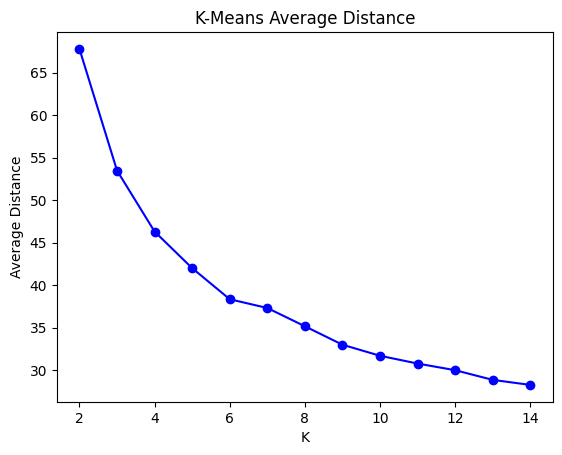

,K,Average Distance,SSE,Silhouette Score
0,2,67.804293,5.142545e+06,0.568779
1,3,53.481902,2.913493e+06,0.510411
2,4,46.295276,2.150743e+06,0.427725
3,5,41.989773,1.737787e+06,0.396890
4,6,38.329162,1.467148e+06,0.329232
5,7,37.296986,1.301444e+06,0.333565
6,8,35.144541,1.147046e+06,0.350330
7,9,32.971853,1.002805e+06,0.339593
8,10,31.672183,9.315840e+05,0.289241
9,11,30.754780,8.747936e+05,0.265443


In [19]:
modelo_kmeans_df(df,15)

In [21]:
def train_decision_tree(X_train, y_train, max_depth=None, min_samples_split=2):
    """
    Función para entrenar decision tree.
    
    Args:
        X_train (array-like): Matriz de características de entrenamiento.
        y_train (array-like): Vector de etiquetas de entrenamiento.
        max_depth (int or None, optional): La profundidad máxima del árbol. 
                                           Si es None, se expande hasta que todas las hojas sean puras o hasta que 
                                           todas las hojas contengan menos de min_samples_split muestras.
        min_samples_split (int, optional): El número mínimo de muestras requeridas para dividir un nodo interno.
    
    Returns:
        model: Modelo decision tree entrenado.
    """
    try:
        model_dt = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split)
        model_dt.fit(X_train, y_train)
        
        return model_dt
    except Exception as e:
        print(f"Error en el entrenamiento: {e}")
        return None

In [22]:
train_decision_tree(X_train, y_train, max_depth=3, min_samples_split=2)

DecisionTreeRegressor(max_depth=3)

In [11]:
def train_linear_regression(X_train, y_train, fit_intercept=True, scale_features=True):
    """
    Función para entrenar linear regression.
    
    Args:
        X_train (array-like): Matriz de características de entrenamiento.
        y_train (array-like): Vector de etiquetas de entrenamiento.
        fit_intercept (bool, optional): Indica si se ajusta el término de intercepción. 
                                        Por defecto, es True.
        scale_features (bool, optional): Indica si se escala la matriz de características. 
                                         Por defecto, es True.
    
    Returns:
        model_lr: Modelo linear regression entrenado.
    """
    try:
        if scale_features:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
        
        model_lr = LinearRegression(fit_intercept=fit_intercept)
        model_lr.fit(X_train, y_train)
        
        return model_lr
    except Exception as e:
        print(f"Error en el entrenamiento: {e}")
        return None


In [12]:
train_linear_regression(X_train, y_train, fit_intercept=True, scale_features=True)

LinearRegression()

### 5. Visualization

In [17]:
def plot_scatter_with_reference(y_test: np.array, predictions: np.array, title: str) -> None:
    """
    Genera un gráfico de dispersión con una línea de referencia para comparar los valores de prueba con los valores predichos.

    Args:
        y_test (array-like): Valores de prueba.
        predictions (array-like): Valores predichos.
        title (str): Título del gráfico.

    Returns:
        None
    """
    try:
        sns.set(style="darkgrid")
        plt.scatter(y_test, predictions, color='blue', label='Valores de prueba vs. Valores predichos')
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Línea de referencia: valores reales = valores predichos
        plt.scatter(y_test, y_test, color='red', label='Valores de prueba')
        plt.xlabel('Valores de prueba')
        plt.ylabel('Valores predichos')
        plt.title(title)
        plt.legend()
        plt.show()
    except Exception as e:
        print("Ocurrió un error al generar el gráfico de dispersión:", str(e))
    finally:
        return None

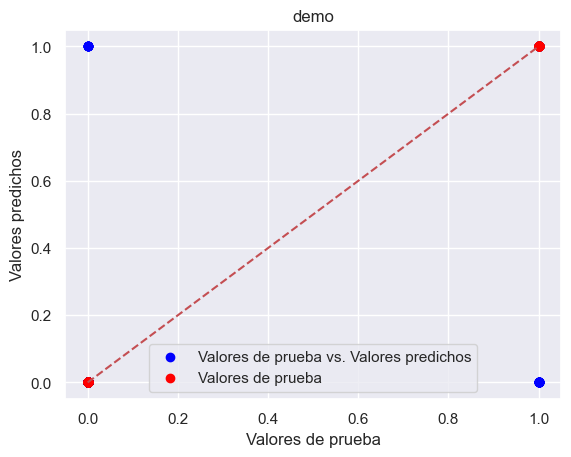

In [18]:
plot_scatter_with_reference(y_test, predictions, 'demo')

In [19]:
def plot_data(dataframe: pd.DataFrame, x: str, y: str, plot_type: str) -> None:
    """Visualiza diferentes tipos de gráficos a partir de un DataFrame.
    
    Args:
        dataframe (pd.DataFrame): El DataFrame que contiene los datos.
        x (str): La columna del DataFrame para el eje x.
        y (str): La columna del DataFrame para el eje y.
        plot_type (str): El tipo de gráfico a crear ('violin', 'scatter', 'bar', etc.).
    """
    try:
        if plot_type == 'violin':
            # Violin plot
            sns.violinplot(x=x, y=y, data=dataframe)
            plt.xlabel(x)
            plt.ylabel(y)
            plt.title('Violin Plot')
        
        elif plot_type == 'scatter':
            # Scatter plot
            plt.scatter(dataframe[x], dataframe[y])
            plt.xlabel(x)
            plt.ylabel(y)
            plt.title('Scatter Plot')
        
        elif plot_type == 'bar':
            # Bar plot
            sns.barplot(x=x, y=y, data=dataframe)
            plt.xlabel(x)
            plt.ylabel(y)
            plt.title('Bar Plot')
        
        # Agregar más tipos de gráficos según sea necesario
        
        plt.show()
    except Exception as e:
        print(f"Ocurrió un error: {str(e)}")

In [21]:
df.columns


Index(['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class'], dtype='object')

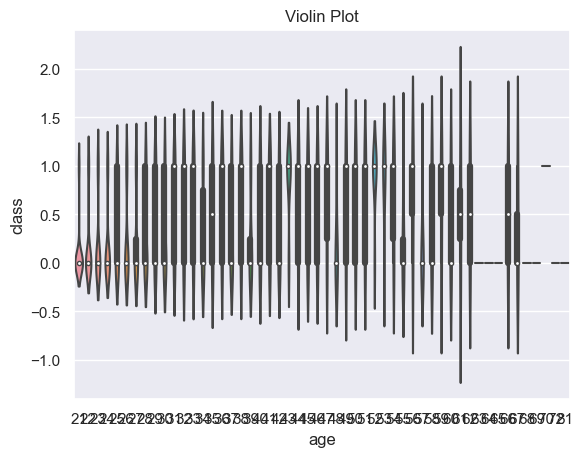

In [22]:
plot_data(df, 'age', 'class', 'violin')